# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Load the data

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Separate features and target

In [3]:
X = train_df.drop(columns=['LoanID', 'Default'])
y = train_df['Default']
X_test = test_df.drop(columns=['LoanID'])

# List of numerical and categorical features

In [4]:
numerical_features = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']
categorical_features = ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']

# Preprocessing for numerical data

In [5]:
# impute missing values, add polynomial features, and scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data

In [6]:
# impute missing values and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocess the data

In [8]:
X_preprocessed = preprocessor.fit_transform(X)
X_test_preprocessed = preprocessor.transform(X_test)

# Define the Logistic Regression model for feature selection

In [9]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Perform Recursive Feature Elimination with Cross-Validation

In [10]:
rfecv = RFECV(estimator=log_reg, step=1, cv=5, scoring='roc_auc')
rfecv.fit(X_preprocessed, y)

RFECV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
      scoring='roc_auc')

# Selected features

In [11]:
selected_features = rfecv.support_

# Select only the important features

In [12]:
X_selected = X_preprocessed[:, selected_features]
X_test_selected = X_test_preprocessed[:, selected_features]

# Define the models with selected features

In [13]:
log_reg_selected = LogisticRegression(max_iter=1000, random_state=42)
rf_clf_selected = RandomForestClassifier(random_state=42)

# Ensemble model

In [14]:
ensemble_model = VotingClassifier(estimators=[
    ('log_reg', log_reg_selected),
    ('rf_clf', rf_clf_selected)
], voting='soft')

# Perform SMOTE to balance the dataset

In [15]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_selected, y)

# Split balanced data into train and validation subsets

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train_balanced, y_train_balanced, test_size=0.2, random_state=42)

# Train ensemble model

In [17]:
ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('log_reg',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('rf_clf',
                              RandomForestClassifier(random_state=42))],
                 voting='soft')

# Get predictions

In [18]:
y_pred = ensemble_model.predict(X_val)
y_pred_proba = ensemble_model.predict_proba(X_val)[:, 1]

# Evaluate the model

In [19]:
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba)

print(f'Ensemble Model Evaluation:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')
print('-' * 30)

Ensemble Model Evaluation:
Accuracy: 0.8857
Precision: 0.8677
Recall: 0.9102
F1 Score: 0.8885
ROC AUC Score: 0.9538
------------------------------


# Predict on the test data

In [20]:
predicted_probabilities = ensemble_model.predict_proba(X_test_selected)[:, 1]

# Threshold the predicted probabilities

In [21]:
threshold = 0.5
predicted_binary = (predicted_probabilities >= threshold).astype(int)

# Create the final prediction DataFrame

In [26]:
prediction_df = pd.DataFrame({'LoanID': test_df['LoanID'], 'predicted_probability': predicted_binary})
prediction_df.to_csv('prediction_submission.csv', index=False)

Binary predictions saved to prediction_submission.csv


# Visualize confusion matrix

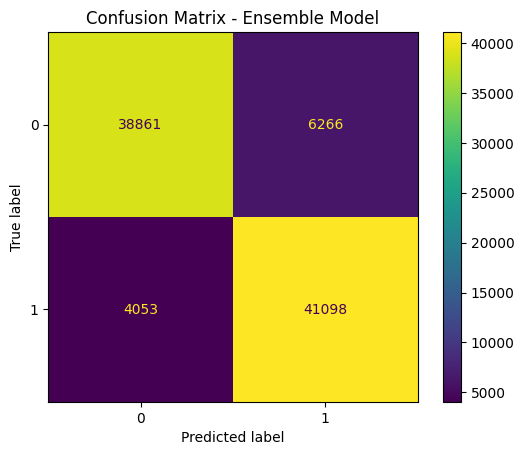

In [23]:
cm = confusion_matrix(y_val, y_pred, labels=ensemble_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ensemble_model.classes_)
disp.plot()
plt.title('Confusion Matrix - Ensemble Model')
plt.show()